### Dataset used:
1. IAM Handwriting Images (https://fki.tic.heia-fr.ch/databases/iam-handwriting-database)
2. Synthetic Word 90K (https://www.robots.ox.ac.uk/~vgg/data/text/) (dataset used in this example)

### Credits:
1. https://github.com/VMD7/Automate-identification-and-recognition-of-handwritten-text-from-an-image
2. An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition by Baoguang Shi, Xiang Bai and Cong Yao School of Electronic Information and Communications Huazhong University of Science and Technology, Wuhan, China


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Reshape,
    BatchNormalization,
    Input,
    Conv2D,
    MaxPooling2D,
    Lambda,
    Bidirectional
)
from tensorflow.keras.models import Model


import os
import shutil
from wintoast import ToastNotifier
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import traceback

In [2]:
current_wd = os.getcwd()
data_folder = current_wd + "\\synthetic word dataset\\mnt\\ramdisk\\max\\90kDICT32px"

In [3]:
data_folder

'C:\\Users\\Usrer\\Desktop\\Data Analysis\\Handwriting OCR Project\\synthetic word dataset\\mnt\\ramdisk\\max\\90kDICT32px'

In [4]:
count = 0
for number in os.listdir(data_folder):
    directories = os.listdir(data_folder + f"\\{number}")
    if directories == []:
        print("Directories:", number, end="\n\n")
        count += 1
        
print("Empty Count: ", count)

Directories: 1687

Directories: 189

Directories: 2059

Directories: 2227

Directories: 2355

Directories: 2549

Directories: 2635

Directories: 3001

Directories: 3002

Directories: 3003

Directories: 3004

Directories: 3005

Directories: 3006

Directories: 3007

Directories: 3008

Directories: 3009

Directories: 3010

Directories: 3011

Directories: 3012

Directories: 3013

Directories: 3014

Directories: 3015

Directories: 3016

Directories: 3017

Directories: 3018

Directories: 3019

Directories: 3020

Directories: 3021

Directories: 3022

Directories: 3023

Directories: 3024

Directories: 3025

Directories: 3026

Directories: 3027

Directories: 3028

Directories: 3029

Directories: 3030

Directories: 3031

Directories: 3032

Directories: 3033

Directories: 3034

Directories: 3035

Directories: 3036

Directories: 3037

Directories: 3038

Directories: 3039

Directories: 3040

Directories: 3041

Directories: 3042

Directories: 3043

Directories: 3044

Directories: 3045

Directories: 

In [8]:
# count how many images are there (total images of the dataset)
count = 0
for number in os.listdir(data_folder):
    
    sub_directories = os.listdir(f"{data_folder}\\{number}")
    
    if sub_directories != []:
        
        for sub_directory in sub_directories:
            
            # get all the images name
            images = os.listdir(f"{data_folder}\\{number}\\{sub_directory}")
            
            for image in images:
                
                count += 1
                
print("Total image count:", count)

Total image count: 8919273


In [6]:
# moving the images from dataset folder to new folder separated with train and testing dir
current_count = 0
total_count = 8919273 # total number of images
train_dir = current_wd + "\\synthetic word dataset\\train"
test_dir = current_wd + "\\synthetic word dataset\\test"

for number in os.listdir(data_folder):
    # iterating the folders
    sub_directories = os.listdir(data_folder + f"\\{number}")
    
    # if this folders have sub-folders
    if sub_directories != []:
        
        for sub_directory in sub_directories:
            
            # get all the images name
            images = os.listdir(f"{data_folder}\\{number}\\{sub_directory}")
            
            for image in images:
                
                # iterating the images 
                if current_count % 10 != 0:
                    
                    # split the image with ratio 9:1 to train:test sets
                    image_location = f"{data_folder}\\{number}\\{sub_directory}\\{image}"
                    shutil.copy(image_location, train_dir)
                    
                else:
                    image_location = f"{data_folder}\\{number}\\{sub_directory}\\{image}"
                    shutil.copy(image_location, test_dir)
                
                current_count += 1
                
                # print progress every 1000 images moved successfully
                if current_count % 1000 == 0:
                    print(f"Current Progress: {(current_count / total_count):.2f}")

# notify me on windows 
toaster = ToastNotifier()
toaster.show_toast(
    "File Operation Completed",
    "All images are moved successfully!",
    duration=30
)

Current Progress: 0.00


WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

WNDPROC return value cannot be converted to LRESULT


TypeError: WPARAM is simple, so must be an int object (got NoneType)

True

### Data Pre-processing

In [8]:
max_label_length = 0
char_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
print(char_list, len(char_list))

def encode_to_labels(text):
    # encoding each output word (each alphabet) to digits
    dig_list = []
    
    for index, character in enumerate(text):
        dig_list.append(char_list.index(character))
        
    return dig_list

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 62


In [4]:
# training and testing directory

training_dir = os.getcwd() + "\\synthetic word dataset\\train"
testing_dir = os.getcwd() + "\\synthetic word dataset\\test"

In [5]:
# array where we storing the images and labels

images = []
labels = []

In [6]:
# arrays where we storing the training and testing images
X_train = []
y_train = []
X_train_length = []
y_train_length = []
train_original_text = []

X_test = []
y_test = []
X_test_length = []
y_test_length = []
test_original_text = []

train_length = []
test_length = []

In [7]:
def process_image(image):
    """
    Converts the image to shape (32, 128, 1) then normalize them by scaling to between 0 and 1
    """
    
    width, height = image.shape
    
    # aspect ratio calculation
    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height, new_width))
    width, height = image.shape
    
    image = image.astype("float32")
    
    # converts each to (32, 128, 1)
    if width < 32:
        add_zeros = np.full((32 - width, height), 255)
        image = np.concatenate((image, add_zeros))
        width, height = image.shape
        
    if height < 128:
        add_zeros = np.full((width, 128 - height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width, height = image.shape
        
    if height > 128 or width > 32:
        dim = (128, 32)
        image = cv2.resize(image, dim)
        
    image = cv2.subtract(255, image)
    image = np.expand_dims(image, axis=2)
    
    # normalize by scaling
    image = image / 255.
    
    return image

In [8]:
training_images_paths = os.listdir(training_dir)[:300000]
testing_images_paths = os.listdir(testing_dir)[:30000]

In [14]:
len(training_images_paths)

400000

In [15]:
len(testing_images_paths)

40000

In [9]:
training_count = 0
testing_count = 0

for train_image_path in training_images_paths:
    
    # read the image
    image = cv2.imread(f"{training_dir}\\{train_image_path}", cv2.IMREAD_GRAYSCALE)
    word = train_image_path.split("_")[1]
    
    # process the image
    try:
        
        image = process_image(image)
        
    except:
        traceback.print_exc()
        continue
        
    # processing on the label
    try:
        label = encode_to_labels(word)
        
    except:
        traceback.print_exc()
        continue
        
    X_train.append(image)
    y_train.append(label)
    X_train_length.append(31)
    y_train_length.append(len(word))
    train_original_text.append(word)
    
    if len(word) > max_label_length:
        max_label_length = len(word)
        
    training_count += 1
    
    if training_count % 1000 == 0:
        print(f"Training Images Progress: {(training_count / 300000):.2f}")
        
for test_image_path in testing_images_paths:
    
    # read the image
    image = cv2.imread(f"{testing_dir}\\{test_image_path}", cv2.IMREAD_GRAYSCALE)
    word = test_image_path.split("_")[1]
    
    # process the image
    try:
        
        image = process_image(image)
        
    except:
        traceback.print_exc()
        continue
        
    # processing on the label
    try:
        label = encode_to_labels(word)
        
    except:
        traceback.print_exc()
        continue
        
    X_test.append(image)
    y_test.append(label)
    X_test_length.append(31)
    y_test_length.append(len(word))
    test_original_text.append(word)
    
    if len(word) > max_label_length:
        max_label_length = len(word)
        
    testing_count += 1
    
    if testing_count % 1000 == 0:   
        print(f"Testing Images Progress: {(testing_count / 30000):.2f}")

Training Images Progress: 0.00
Training Images Progress: 0.01
Training Images Progress: 0.01
Training Images Progress: 0.01
Training Images Progress: 0.02
Training Images Progress: 0.02
Training Images Progress: 0.02
Training Images Progress: 0.03
Training Images Progress: 0.03
Training Images Progress: 0.03
Training Images Progress: 0.04
Training Images Progress: 0.04
Training Images Progress: 0.04
Training Images Progress: 0.05
Training Images Progress: 0.05
Training Images Progress: 0.05
Training Images Progress: 0.06
Training Images Progress: 0.06


Traceback (most recent call last):
  File "C:\Users\Usrer\AppData\Local\Temp\ipykernel_17916\1844755382.py", line 13, in <module>
    image = process_image(image)
  File "C:\Users\Usrer\AppData\Local\Temp\ipykernel_17916\800697168.py", line 6, in process_image
    width, height = image.shape
AttributeError: 'NoneType' object has no attribute 'shape'


Training Images Progress: 0.06
Training Images Progress: 0.07
Training Images Progress: 0.07
Training Images Progress: 0.07
Training Images Progress: 0.08
Training Images Progress: 0.08
Training Images Progress: 0.08
Training Images Progress: 0.09
Training Images Progress: 0.09
Training Images Progress: 0.09
Training Images Progress: 0.10
Training Images Progress: 0.10
Training Images Progress: 0.10
Training Images Progress: 0.11
Training Images Progress: 0.11
Training Images Progress: 0.11
Training Images Progress: 0.12
Training Images Progress: 0.12
Training Images Progress: 0.12
Training Images Progress: 0.13
Training Images Progress: 0.13
Training Images Progress: 0.13
Training Images Progress: 0.14
Training Images Progress: 0.14
Training Images Progress: 0.14
Training Images Progress: 0.15
Training Images Progress: 0.15
Training Images Progress: 0.15
Training Images Progress: 0.16
Training Images Progress: 0.16
Training Images Progress: 0.16
Training Images Progress: 0.17
Training

Training Images Progress: 0.95
Training Images Progress: 0.95
Training Images Progress: 0.95
Training Images Progress: 0.96
Training Images Progress: 0.96
Training Images Progress: 0.96
Training Images Progress: 0.97
Training Images Progress: 0.97
Training Images Progress: 0.97
Training Images Progress: 0.98
Training Images Progress: 0.98
Training Images Progress: 0.98
Training Images Progress: 0.99
Training Images Progress: 0.99
Training Images Progress: 0.99
Training Images Progress: 1.00
Testing Images Progress: 0.03
Testing Images Progress: 0.07
Testing Images Progress: 0.10
Testing Images Progress: 0.13
Testing Images Progress: 0.17
Testing Images Progress: 0.20
Testing Images Progress: 0.23
Testing Images Progress: 0.27
Testing Images Progress: 0.30
Testing Images Progress: 0.33
Testing Images Progress: 0.37
Testing Images Progress: 0.40
Testing Images Progress: 0.43
Testing Images Progress: 0.47
Testing Images Progress: 0.50
Testing Images Progress: 0.53
Testing Images Progress:

In [10]:
X_train = np.asarray(X_train)
X_train_length = np.asarray(X_train_length)
y_train_length = np.asarray(y_train_length)

X_test = np.asarray(X_test)
X_test_length = np.asarray(X_test_length)
y_test_length = np.asarray(y_test_length)

In [11]:
train_padded_label = pad_sequences(
    y_train,
    maxlen=max_label_length,
    padding="post",
    value=len(char_list)
)

test_padded_label = pad_sequences(
    y_test,
    maxlen=max_label_length,
    padding="post",
    value=len(char_list)
)

### Model Construction and Training

In [9]:
# constructing the model
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
pool_1 = MaxPooling2D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(pool_1)
pool_2 = MaxPooling2D(pool_size=2, strides=2)(conv_2)

conv_3 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(pool_2)
conv_4 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(conv_3)
pool_4 = MaxPooling2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPooling2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(filters=512, kernel_size=(2, 2), activation="relu")(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)
outputs = Dense(len(char_list) + 1, activation="softmax")(blstm_2) # 79 char list

act_model = Model(inputs, outputs)

In [20]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 32, 256)        2951

In [13]:
def ctc_lambda_function(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
the_labels = tf.keras.layers.Input(name="the_labels", shape=[max_label_length], dtype="float32")
input_length = tf.keras.layers.Input(name="input_length", shape=[1], dtype="int64")
label_length = tf.keras.layers.Input(name="label_length", shape=[1], dtype="int64")

In [15]:
loss_out = Lambda(ctc_lambda_function, output_shape=(1, ), name="ctc")([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [16]:
model.compile(
    loss={'ctc': lambda y_true, y_pred,: y_pred},
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"]
)

In [17]:
history = model.fit(
    x=[X_train, train_padded_label, X_train_length, y_train_length],
    y=np.zeros(len(X_train)),
    batch_size=32,
    epochs=30,
    validation_data=([X_test, test_padded_label, X_test_length, y_test_length], [np.zeros(len(X_test))]),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)]
)

Epoch 1/30
9375/9375 [==============================] - 466s 48ms/step - loss: 16.0166 - accuracy: 0.0449 - val_loss: 5.8286 - val_accuracy: 0.1693
Epoch 2/30
9375/9375 [==============================] - 446s 48ms/step - loss: 4.9135 - accuracy: 0.2316 - val_loss: 4.3773 - val_accuracy: 0.2970
Epoch 3/30
9375/9375 [==============================] - 447s 48ms/step - loss: 4.1640 - accuracy: 0.3108 - val_loss: 3.9752 - val_accuracy: 0.3462
Epoch 4/30
9375/9375 [==============================] - 443s 47ms/step - loss: 3.8063 - accuracy: 0.3526 - val_loss: 3.8052 - val_accuracy: 0.3910
Epoch 5/30
9375/9375 [==============================] - 457s 49ms/step - loss: 3.5840 - accuracy: 0.3777 - val_loss: 3.6951 - val_accuracy: 0.4318
Epoch 6/30
9375/9375 [==============================] - 444s 47ms/step - loss: 3.4358 - accuracy: 0.3939 - val_loss: 3.7693 - val_accuracy: 0.3718
Epoch 7/30
9375/9375 [==============================] - 454s 48ms/step - loss: 3.3004 - accuracy: 0.4142 - val_loss: 

In [42]:
model.save("trained_modelv2.h5")

In [26]:
act_model.set_weights(model.get_weights())

In [39]:
def predict_image():
    path = os.getcwd() + "\\test.png"
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = process_image(image)
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    prediction = act_model.predict(np.asarray([image]))
    
    decoded = K.ctc_decode(
        prediction,
        input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
        greedy=True
    )[0][0]
    out = K.get_value(decoded)
    
    for i, x in enumerate(out):
        text = ""
        for p in x:
            if int(p) != -1:
                text += char_list[int(p)]
                
        print(text)

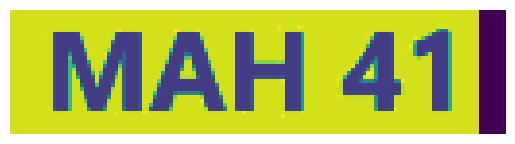

1/1 [==============================] - 0s 53ms/step
MAHAI


In [41]:
predict_image()

### OCR System Flow

1. Segment the image by lines and words
2. Sort all the segmented images (word) by the coordinates on the image
3. Feed segmented images (single english word) into the model
4. Connects all predicted words using `join()` method with `" "`.

In [14]:
# functions required for image-preprocessing before converting to text

def threshold_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

def read_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, colours = img.shape
    
    if width > 1000:
        
        new_width = 1000
        aspect_ratio = width / height
        new_height = int(new_width / aspect_ratio)
        
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        
    thresh_img = threshold_image(img)
        
    return img, thresh_img

def segment_line(img, thresh_img):
    
    # dilate image
    kernel = np.ones((3, 85), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)
    
    # find contours of lines
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[1]) # sort according to y
    
    for contour in sorted_contours_lines:
        x, y, width, height = cv2.boundingRect(contour)
        #cv2.rectangle(test_img, (x, y), (x + width, y + height), (0, 255, 0), 2) # needs left corner coords and bottom right corners coords
    
    return sorted_contours_lines

def segment_words(img, thresh_img):
    
    show_image = img.copy()
    words = []
    lines = segment_line(img, thresh_img)
    
    # dilate the image
    kernel = np.ones((3, 14), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)
    
    for line in lines:
        
        # roi of each line
        x, y, width, height = cv2.boundingRect(line)
        roi_line = dilated[y:y+height, x:x+width]
        
        # draw contours on each word
        contours, hierarchy = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contours_words = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0]) # sort according to x
        
        for word_contour in sorted_contours_words:
            
            if cv2.contourArea(word_contour) < 100:
                continue
                
            x2, y2, width2, height2 = cv2.boundingRect(word_contour)
            words.append([x+x2, y+y2, x+x2+width2, y+y2+height2])
            cv2.rectangle(show_image, (x+x2, y+y2), (x+x2+width2, y+y2+height2), (0, 255, 0), 1)
            
    plt.imshow(show_image)
    return words

def process_segmented_image(img):
    """
    Converts image to shape 32, 128, 1) & normalize
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    width, height = img.shape
    
    # aspect ratio calculation
    new_width = 32
    new_height = int(height * (new_width / width))
    img = cv2.resize(img, (new_height, new_width))
    width, height = img.shape
    
    img = img.astype("float32")
    
    # converts each to (32, 128, 1)
    if width < 32:
        add_zeros = np.full((32 - width, height), 255)
        img = np.concatenate((img, add_zeros))
        width, height = img.shape
        
    if height < 128:
        add_zeros = np.full((width, 128 - height), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        width, height = img.shape
        
    if height > 128 or width > 32:
        dim = (128, 32)
        img = cv2.resize(img, dim)
        
    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    
    # normalize (rescale between 0 and 1)
    img = img / 255.
    
    return img

def predict_img(image):
    # predict word on segmented image
    img = np.asarray([process_segmented_image(image)])
    prediction = act_model.predict(img)
    
    decoded = K.ctc_decode(
        prediction,
        input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
        greedy=True
    )[0][0]
    out = K.get_value(decoded)
    
    for i, x in enumerate(out):
        text = ""
        for p in x:
            if int(p) != -1:
                text += char_list[int(p)]
    
    return text

def predict_img_text(filepath):
    # predict on complete image (not segmented image)
    img, thresh_img = read_img(filepath)
    test_image = img.copy()

    words = segment_words(img, thresh_img)
    whole_text = []

    for word in words:
        segmented = test_image[word[1]:word[3], word[0]: word[2]]
        predicted_word = predict_img(segmented)
        whole_text.append(predicted_word)

    whole_text = " ".join(whole_text)
    print("Whole paragraph: \n\n", whole_text)

### Conclusion


#### Preprocessing
Basically the image first need to be resized and converted to grayscale before doing other preprocessing tasks. After the images are converted to grayscale, then the image needs to be thresholded using `cv2.threshold(img, min, max, algo_used)` which returns `ret` and `thresh`. Thresholding helps removing the noises to make the element we want to capture clearer. Then, the image is dilated with different kernel parameters with `cv2.dilate(img, kernel, iterations)` which helps to further remove noises and bolds the element we want to capture so that cv2 can easily segments the words and lines from the background.

#### Segmentation
The lines and words is then segmented from the image with `cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)` which returns `contours` and `hierarchy`. Then, the contours obtained is sorted with `sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[1])` function to arrange the words nicely.

### Loading up model's weights without having to re-train

In [8]:
max_label_length = 0
char_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
print(char_list, len(char_list))

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 62


In [9]:
# constructing the model
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
pool_1 = MaxPooling2D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(pool_1)
pool_2 = MaxPooling2D(pool_size=2, strides=2)(conv_2)

conv_3 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(pool_2)
conv_4 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(conv_3)
pool_4 = MaxPooling2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPooling2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(filters=512, kernel_size=(2, 2), activation="relu")(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)
outputs = Dense(len(char_list) + 1, activation="softmax")(blstm_2) # 79 char list

act_model = Model(inputs, outputs)

In [11]:
act_model.load_weights("trained_modelv2.h5")

1/1 [==============================] - 0s 53ms/step
Whole paragraph: 

 MAHAI


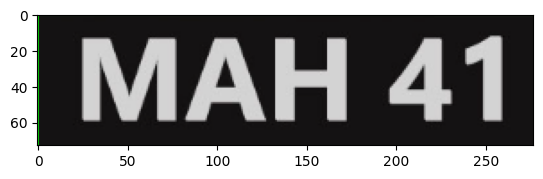

In [15]:
predict_img_text("test.png")

1/1 [==============================] - 0s 54ms/step
Whole paragraph: 

 Chimpanzees


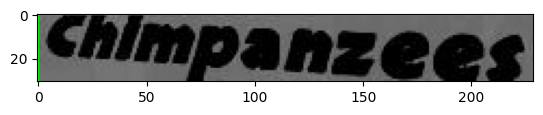

In [16]:
predict_img_text("test2.jpg")

1/1 [==============================] - 0s 53ms/step
Whole paragraph: 

 Ex  1th


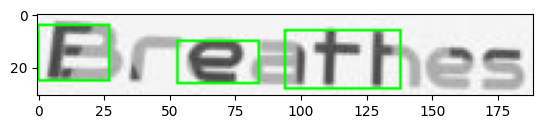

In [17]:
predict_img_text("test3.jpg")

### Limitation:

1. As this is a word-based predictor, which means the performance of this model depends on the segmentation techniques used for the image pre-processing steps. As shown above, the image segmentation fails to segments image in correct manner when single word image is fed into the system. 
2. Besides, the model also fails to predict when there are combination of digits and alphabets in the image as shown in the first example. This can be addressed by adding more samples data so that the model can extract useful pattern on this aspect.
3. The model can't also handle punctuation as this model is trained with synthetic word 90K dataset which does not have realistic english sentences which consists of alphabets, digits, and punctuations (including spaces).